In [1]:
using Distributions
using PyPlot
using Random
using LinearAlgebra
using StatsBase
using DifferentialEquations
using StatsBase
using ProgressBars

In [2]:
function p_from_rate(x::Array,delta_t)
    # Compute the probability of transition from the rate in the case of the multi-patch model
    
    return -exp.(-x .* delta_t) .+ 1
end

p_from_rate (generic function with 1 method)

In [3]:
function p_from_rate_single_patch(x::Float64,delta_t)
    # Compute the probability of transition from the rate in the case of the single-patch model
    
    return -exp(-x * delta_t) + 1
end

p_from_rate_single_patch (generic function with 1 method)

In [4]:
function force_infection(map::Array, I::Array, beta::Float64)
    # Compute the force of infection for every tile of the multi-patch model
    
    return map * I * beta
end

force_infection (generic function with 1 method)

In [5]:
function SEIRS_single_patch(T,delta_t,population::Int64,First_cases::Int64,parameters) 
#= T is the total observation time (days)
   dt is the time-step (days)
   N is the total population in study
   First_cases is the number of first infected inserted in the sample
   parameters is a dictionary of values for the parameters defining the mathematical process =#
    
    N_iterations=convert(Int64,round(T/delta_t))
    p_mu=p_from_rate_single_patch(parameters["mu"],delta_t)
    p_alpha=p_from_rate_single_patch(parameters["alpha"],delta_t)
    p_omega=p_from_rate_single_patch(parameters["omega"],delta_t)
    S=zeros(Int64,N_iterations)
    I=zeros(Int64,N_iterations)
    R=zeros(Int64,N_iterations)
    E=zeros(Int64,N_iterations)
    I[1]=First_cases
    S[1]=population-I[1]
    for t = range(1,N_iterations-1)
        p_beta=p_from_rate_single_patch(parameters["k"]*parameters["beta"]*I[t]/population,delta_t)
        E_new=rand(Binomial(S[t],p_beta))
        I_new=rand(Binomial(E[t],p_alpha))
        R_new=rand(Binomial(I[t],p_mu))
        S_new=rand(Binomial(R[t],p_omega))
        E[t+1]=E[t]+E_new-I_new
        I[t+1]=I[t]+I_new-R_new
        R[t+1]=R[t]+R_new-S_new
        S[t+1]=population-E[t+1]-I[t+1]-R[t+1]
        #if (I[t+1]+E[t+1]==0)
         #   return S,E,I,R
        #end
    end
    return S,E,I,R
end

SEIRS_single_patch (generic function with 1 method)

In [6]:
function SEIRS_multi_patch(T,delta_t,N::Array,First_cases::Array,parameters,Tiles::Int64, map::Array)
#= T is the total observation time (days)
   dt is the time-step (days)
   N is the array of total population in study in each tile
   First_cases is the array of first infected inserted in the sample
   parameters is a dictionary of values for the parameters defining the mathematical process =#

    N_iterations=convert(Int64,round(T/delta_t))
    p_mu=p_from_rate_single_patch(parameters["mu"],delta_t)
    p_alpha=p_from_rate_single_patch(parameters["alpha"],delta_t)
    p_omega=p_from_rate_single_patch(parameters["omega"],delta_t)
    S=zeros(Int64,N_iterations,Tiles)
    I=zeros(Int64,N_iterations,Tiles)
    R=zeros(Int64,N_iterations,Tiles)
    E=zeros(Int64,N_iterations,Tiles)
    I[1,:]=First_cases
    S[1,:] .= N .- I[1,:]
    for t = range(1,N_iterations-1)
        p_beta=p_from_rate(force_infection(map.*N,I[t,:]./N,parameters["beta"]),delta_t)
        for i = range(1,Tiles)
            E_new=rand(Binomial(S[t,i],p_beta[i]))
            I_new=rand(Binomial(E[t,i],p_alpha))
            R_new=rand(Binomial(I[t,i],p_mu))
            S_new=rand(Binomial(R[t,i],p_omega))
            E[t+1,i]=E[t,i]+E_new-I_new
            I[t+1,i]=I[t,i]+I_new-R_new
            R[t+1,i]=R[t,i]+R_new-S_new
            S[t+1,i]=N[i]-E[t+1,i]-I[t+1,i]-R[t+1,i]
        end
        #if (sum(I[t+1,:])+sum(E[t+1,:])==0)
         #   return S,E,I,R
        #end
    end
    return S,E,I,R
end

SEIRS_multi_patch (generic function with 1 method)

In [7]:
function SEIRS_ODE!(du,u,p,t)
    #= ODE version of the single patch stochastic model:
       p[1] is the beta rate (S-->E),
       p[2] is the alpha rate (E-->I),
       p[3] is the mu rate (I-->R),
       p[4] is the omega rate (R-->S),
       p[5] is the total population,
       p[6] is the fraction of contacts k =#
    
    E,I,R=u
    S=p[5] - E - I - R
    du[1] = (p[1]*p[6]/p[5])*S*I - p[2]*E
    du[2] = p[2]*E - p[3]*I
    du[3] = p[3]*I - p[4]*R
end 

SEIRS_ODE! (generic function with 1 method)

In [8]:
function SEIRS_ODE_multi!(du,u,params,t)
    #= ODE version of the multi-patch stochastic model:
       p[1] is the beta rate (S-->E),
       p[2] is the alpha rate (E-->I),
       p[3] is the mu rate (I-->R),
       p[4] is the omega rate (R-->S),
       N is the total population,
       map is the colocation map between tiles =#
    
    N,map,p=params
    force_of_infection=force_infection(map.*N,u[2,:]./N,p[1])    
    Tiles=size(map,1)
    for i = range(1,Tiles) 
        S=N[i]-u[1,i]-u[2,i]-u[3,i]
        du[1,i] = force_of_infection[i]*S - p[2]*u[1,i]
        du[2,i] = p[2]*u[1,i] - p[3]*u[2,i]
        du[3,i] = p[3]*u[2,i] - p[4]*u[3,i]
    end
end 

SEIRS_ODE_multi! (generic function with 1 method)

In [9]:
params = Dict("mu"=>1/(7+2.1),
    "omega"=>0.5,
    "alpha"=>1/3.7,
    "k"=>1.0,
    "beta"=>0.05,
    "N_0"=>1000.0) #values from Piero's, except for omega

Dict{String, Float64} with 6 entries:
  "N_0"   => 1000.0
  "omega" => 0.5
  "alpha" => 0.27027
  "k"     => 1.0
  "mu"    => 0.10989
  "beta"  => 0.05

# Single patch model

### $R_0$ for single patch

In [10]:
params["k"]*params["beta"]/params["mu"]

0.455

### Initial conditions

In [67]:
T=500
dt=0.01
N_0=convert(Int64,params["N_0"])
Iterations_single=1000

1000

### Stochastic simulation

In [27]:
test_single_patch=[]
for i = range(1,Iterations_single)
    S,E,I,R=SEIRS_single_patch(T,dt,N_0,1,params)
    push!(test_single_patch,I)
end

## Test with EV notebook

### Running the corresponsing ODE

In [28]:
# Define the initial condition
S_0=N_0-1
E_0=0.0
I_0=1.0
R_0=0.0

# Define the range of x values
tspan = (0.0, convert(Float64,T))

# Create an ODE problem
prob = ODEProblem(SEIRS_ODE!,
    [E_0,I_0,R_0],
    tspan,
    [params["beta"],params["alpha"],params["mu"],params["omega"],params["N_0"],params["k"]])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: 3-element Vector{Float64}:
 0.0
 1.0
 0.0

In [29]:
# Solve the ODE with the custom time step
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 49-element Vector{Float64}:
   0.0
   0.003129590293244787
   0.034425493225692654
   0.19005756443090827
   0.49988521567793726
   0.9324951577196666
   1.4912754063955465
   2.197998920172946
   3.0625180553587485
   4.106637936316627
   5.354246082243994
   6.846331924490911
   8.643465078932593
   ⋮
 140.3704439560988
 146.69281988292673
 153.05113725476411
 159.44501909634837
 165.8598801051171
 172.27957832714716
 178.69376415772595
 191.50495501246314
 208.12553886893647
 240.79017887907176
 313.96498873871263
 500.0
u: 49-element Vector{Vector{Float64}}:
 [0.0, 1.0, 0.0]
 [0.0009373801164194031, 0.9996565445771358, 0.00034358303203416927]
 [0.010250152472764097, 0.9962718536250904, 0.003743603386986009]
 [0.054966596635391086, 0.9807497144537854, 0.01972362948736604]
 [0.13672241990632505, 0.9558927595461022, 0.04740446415227285]
 [0.23702060

### Plots to confront results between stochastic and ODE

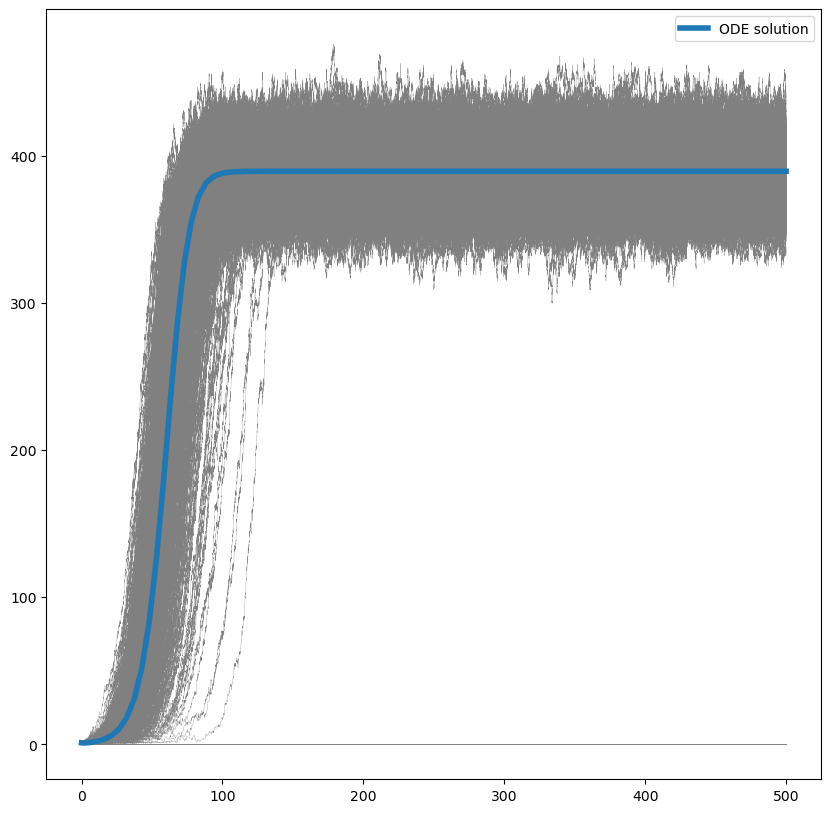

In [30]:
figure()
subplots(figsize=(10,10))
for i = range(1,1000)
    plot(LinRange(1,T,convert(Int64,T/dt)),test_single_patch[i], linewidth=0.2, c="grey")
end
plot(sol.t,sol[2,:],linewidth=4.0, label="ODE solution")
legend()
#savefig("/Users/claudioascione/Desktop/Grafici/Testing_SEIRS_model/Model_SEIRS_single_Patch_ODE_vs_stoch", dpi=200)

In [31]:
test_single_patch_matrix=mapreduce(permutedims, vcat, test_single_patch)

1000×50000 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  379  378  378  377  377  377  377
 1  1  1  1  1  1  1  1  1  1  1  1  1       0    0    0    0    0    0    0
 1  1  1  1  1  1  1  1  1  1  1  1  1       0    0    0    0    0    0    0
 1  1  1  1  1  1  1  1  1  1  1  1  1       0    0    0    0    0    0    0
 1  1  1  1  1  1  1  1  1  1  1  1  1     395  395  394  394  395  395  395
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  381  381  380  380  379  379  379
 1  1  1  1  1  1  1  1  1  1  1  1  1     413  413  413  413  413  412  413
 1  1  1  1  1  1  1  1  1  1  1  1  1     389  389  387  386  386  386  386
 1  1  1  1  1  1  1  1  1  1  1  1  1     343  343  344  345  347  346  345
 1  1  1  1  1  1  1  1  1  1  1  1  1     416  416  416  416  416  414  416
 1  1  1  1  1  1  1  1  1  1  1  1  1  …    0    0    0    0    0    0    0
 1  1  1  1  1  1  1  1  1  1  1  1  1     367  367  367  367  367  367  365
 1  1  1  1  1  1  1  1  1  1  1  1  1       0    

In [32]:
vec_percent=[]
for i = range(1,size(test_single_patch_matrix,2))
    push!(vec_percent,percentile(test_single_patch_matrix[:,i],[2.5,50,97.5]))
end

In [33]:
vec_percent=mapreduce(permutedims, vcat, vec_percent)

50000×3 Matrix{Float64}:
 1.0    1.0    1.0
 1.0    1.0    1.0
 1.0    1.0    1.0
 1.0    1.0    1.0
 1.0    1.0    1.0
 1.0    1.0    1.0
 1.0    1.0    1.0
 1.0    1.0    1.0
 1.0    1.0    1.0
 1.0    1.0    1.0
 1.0    1.0    1.0
 1.0    1.0    1.0
 1.0    1.0    1.0
 ⋮           
 0.0  372.0  419.0
 0.0  372.0  419.025
 0.0  372.0  420.0
 0.0  372.0  419.0
 0.0  372.0  419.0
 0.0  372.0  419.0
 0.0  372.0  419.0
 0.0  372.5  419.0
 0.0  373.0  419.0
 0.0  373.0  419.0
 0.0  373.0  419.0
 0.0  373.0  418.0

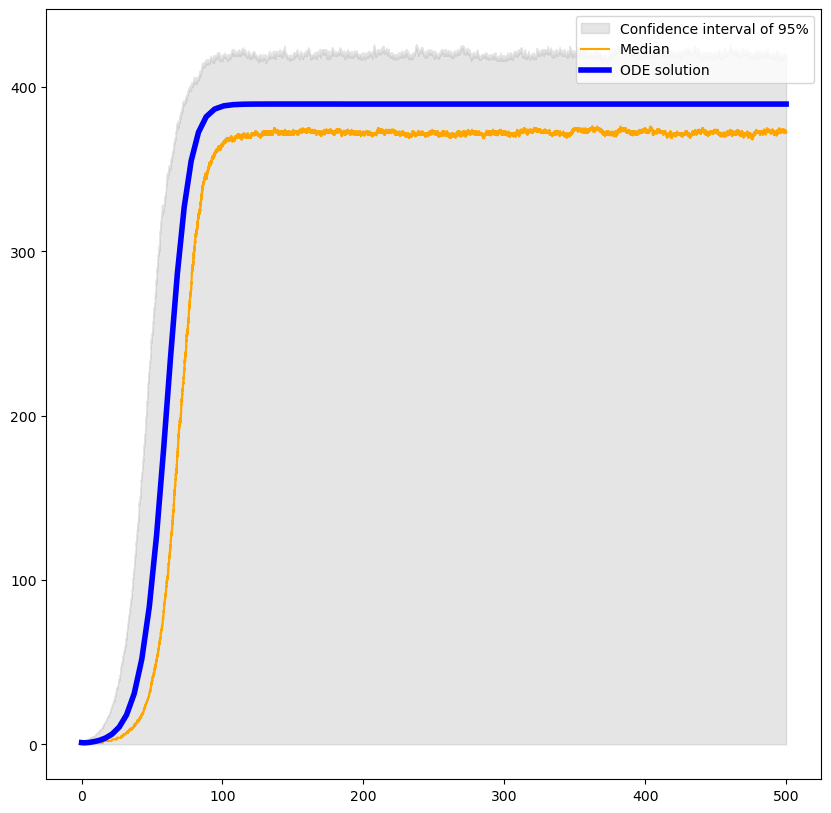

In [34]:
figure()
subplots(figsize=(10,10))
fill_between(LinRange(1,T,convert(Int64,T/dt)), vec_percent[:, 1], vec_percent[:, 3],alpha=0.2, color="grey",label="Confidence interval of 95%")
plot(LinRange(1,T,convert(Int64,T/dt)),vec_percent[:,2], c="orange", label="Median")
plot(sol.t,sol[2,:],linewidth=4.0, c="blue", label="ODE solution")
legend()
#savefig("/Users/claudioascione/Desktop/Grafici/Testing_SEIRS_model/Model_SEIRS_single_Patch_ODE_vs_stoch_CI", dpi=200)

#### Now, we eliminate the stochastic simulation that happen to incur into stochastic extinction

In [35]:
test_single_patch_matrix_no_extinction=test_single_patch_matrix[test_single_patch_matrix[:,10000] .> 0,:]

607×50000 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  379  378  378  377  377  377  377
 1  1  1  1  1  1  1  1  1  1  1  1  1     395  395  394  394  395  395  395
 1  1  1  1  1  1  1  1  1  1  1  1  1     381  381  380  380  379  379  379
 1  1  1  1  1  1  1  1  1  1  1  1  1     413  413  413  413  413  412  413
 1  1  1  1  1  1  1  1  1  1  1  1  1     389  389  387  386  386  386  386
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  343  343  344  345  347  346  345
 1  1  1  1  1  1  1  1  1  1  1  1  1     416  416  416  416  416  414  416
 1  1  1  1  1  1  1  1  1  1  1  1  1     367  367  367  367  367  367  365
 1  1  1  1  1  1  1  1  1  1  1  1  1     390  390  391  392  392  391  392
 1  1  1  1  1  1  1  1  1  1  1  1  1     407  407  407  407  407  407  408
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  412  412  412  412  413  412  411
 1  1  1  1  1  1  1  1  1  1  1  1  1     405  405  406  407  407  408  409
 1  1  1  1  1  1  1  1  1  1  1  1  1     372  372

In [36]:
vec_percent_no_extinction=[]
for i = range(1,size(test_single_patch_matrix_no_extinction,2))
    push!(vec_percent_no_extinction,percentile(test_single_patch_matrix_no_extinction[:,i],[2.5,50,97.5]))
end

In [37]:
vec_percent_no_extinction=mapreduce(permutedims, vcat, vec_percent_no_extinction)

50000×3 Matrix{Float64}:
   1.0     1.0    1.0
   1.0     1.0    1.0
   1.0     1.0    1.0
   1.0     1.0    1.0
   1.0     1.0    1.0
   1.0     1.0    1.0
   1.0     1.0    1.0
   1.0     1.0    1.0
   1.0     1.0    1.0
   1.0     1.0    1.0
   1.0     1.0    1.0
   1.0     1.0    1.0
   1.0     1.0    1.0
   ⋮            
 352.0   389.0  421.85
 352.0   389.0  422.0
 352.0   389.0  422.0
 352.15  389.0  422.0
 352.0   389.0  421.85
 351.15  389.0  420.0
 352.0   389.0  421.0
 352.0   389.0  421.0
 351.15  389.0  421.0
 352.0   389.0  421.0
 351.15  389.0  421.0
 351.15  389.0  421.0

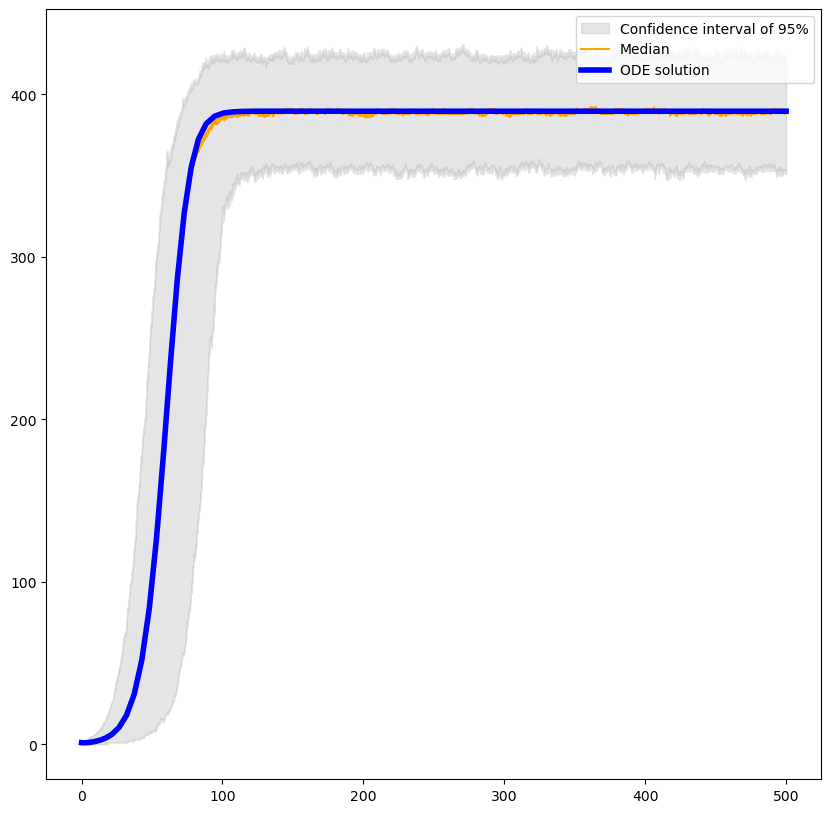

In [38]:
figure()
subplots(figsize=(10,10))
fill_between(LinRange(1,T,convert(Int64,T/dt)), vec_percent_no_extinction[:, 1], vec_percent_no_extinction[:, 3],alpha=0.2, color="grey", label="Confidence interval of 95%")
plot(LinRange(1,T,convert(Int64,T/dt)),vec_percent_no_extinction[:,2], c="orange", label="Median")
plot(sol.t,sol[2,:],linewidth=4.0, c="blue", label="ODE solution")
legend()
#savefig("/Users/claudioascione/Desktop/Grafici/Testing_SEIRS_model/Model_SEIRS_single_Patch_ODE_vs_stoch_CI_no_extinction", dpi=200)

# Multi-patch model

### Initial conditions

In [48]:
T=500
dt=0.01
N_multi=params["N_0"]
Iterations_multi=100
Tiles=5
sintetic_coloc_map=Matrix(Symmetric(rand(Tiles,Tiles)./100))

5×5 Matrix{Float64}:
 0.00786653  0.00700775  0.00869809  0.00540633  0.0046782
 0.00700775  0.00756417  0.00131158  0.00706698  0.00179101
 0.00869809  0.00131158  0.00617679  0.00994762  0.0049904
 0.00540633  0.00706698  0.00994762  0.00720605  0.00674712
 0.0046782   0.00179101  0.0049904   0.00674712  0.00594531

In [49]:
N=fill(N_multi,Tiles)
First_cases=zeros(Int64,Tiles)
First_cases[1]=1

1

### $R_0$ for multi-patch (biggest eigenvalue of the matrix)

In [51]:
eigvals((sintetic_coloc_map.*N) * params["beta"])

5-element Vector{Float64}:
 -0.330346684531526
  0.051720822744964215
  0.1384531113135588
  0.34016555029358947
  1.5379501184660607

### Stochastic simulation

In [37]:
test = []
for i = 1:Iterations_multi
    S_multi, E_multi, I_multi, R_multi = SEIRS_multi_patch(T, dt, N, First_cases, params, Tiles, sintetic_coloc_map)
    push!(test, I_multi)
end

## Test with EV notebook

### Running the corresponsing ODE

In [45]:
# Define the initial condition
N_0_multi=fill(convert(Float64,N_multi),Tiles)
E_0_multi=zeros(Float64,Tiles)
I_0_multi=zeros(Float64,Tiles)
I_0_multi[1]=1.0
R_0_multi=zeros(Float64,Tiles)
Initial_conditions=transpose([E_0_multi I_0_multi R_0_multi])


# Define the range of x values
tspan = (0.0, convert(Float64,T))

# Create an ODE problem
prob = ODEProblem(SEIRS_ODE_multi!,
    Initial_conditions,
    tspan,
    (N_0_multi,sintetic_coloc_map,[params["beta"],params["alpha"],params["mu"],params["omega"]])
)

ODEProblem with uType Transpose{Float64, Matrix{Float64}} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: 3×5 transpose(::Matrix{Float64}) with eltype Float64:
 0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [27]:
# Solve the ODE with the custom time step
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 52-element Vector{Float64}:
   0.0
   0.005096390952436908
   0.056060300476805984
   0.24540826856749012
   0.5385422841337936
   0.8928558509392192
   1.3502638631030002
   1.9076593218968343
   2.6041753396286134
   3.463580946430362
   4.532348527745504
   5.854031654914627
   7.473185027222533
   ⋮
 162.5304946708284
 168.90771302572128
 175.28746452252676
 181.68717590408016
 188.10746453197993
 194.54011081496708
 200.97567510608056
 213.840279496704
 230.5477988948926
 263.44098699767966
 337.13788402959426
 500.0
u: 52-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.000492020458838873 0.00042479263633129333 … 0.00039858237869657673 0.00031862258224206176; 0.9994404527343523 2.9259514763625323e-7 … 2.745416345109018e-7 2.194657092446715e-7; 0.0005591734195917236 5.459852858145653e-11 … 5.1229725

### Plots to confront results between stochastic and ODE

In [28]:
I_multi=[]
for i = range(1,size(sol.u,1))
    push!(I_multi,sol.u[i][2,:])
end
I_multi=mapreduce(permutedims, vcat, I_multi)

52×5 Matrix{Float64}:
   1.0         0.0            0.0            0.0            0.0
   0.99944     2.92595e-7     7.1887e-9      2.74542e-7     2.19466e-7
   0.993899    3.51112e-5     8.62763e-7     3.29449e-5     2.63358e-5
   0.974148    0.000652589    1.60777e-5     0.000612381    0.000489517
   0.94601     0.0030002      7.46899e-5     0.00281635     0.00225106
   0.915575    0.00780832     0.000198802    0.00733554     0.00586179
   0.881365    0.0166816      0.000443577    0.0156959      0.0125366
   0.846284    0.0307515      0.000878203    0.0290126      0.0231538
   0.810878    0.0521619      0.00166282     0.0494357      0.0393979
   0.777515    0.082808       0.00307926     0.0790456      0.0628555
   0.748341    0.12539        0.00569505     0.121016       0.0958977
   0.726557    0.182709       0.0105278      0.179177       0.141257
   0.716241    0.258231       0.0192904      0.258808       0.202558
   ⋮                                                      
 353.192   

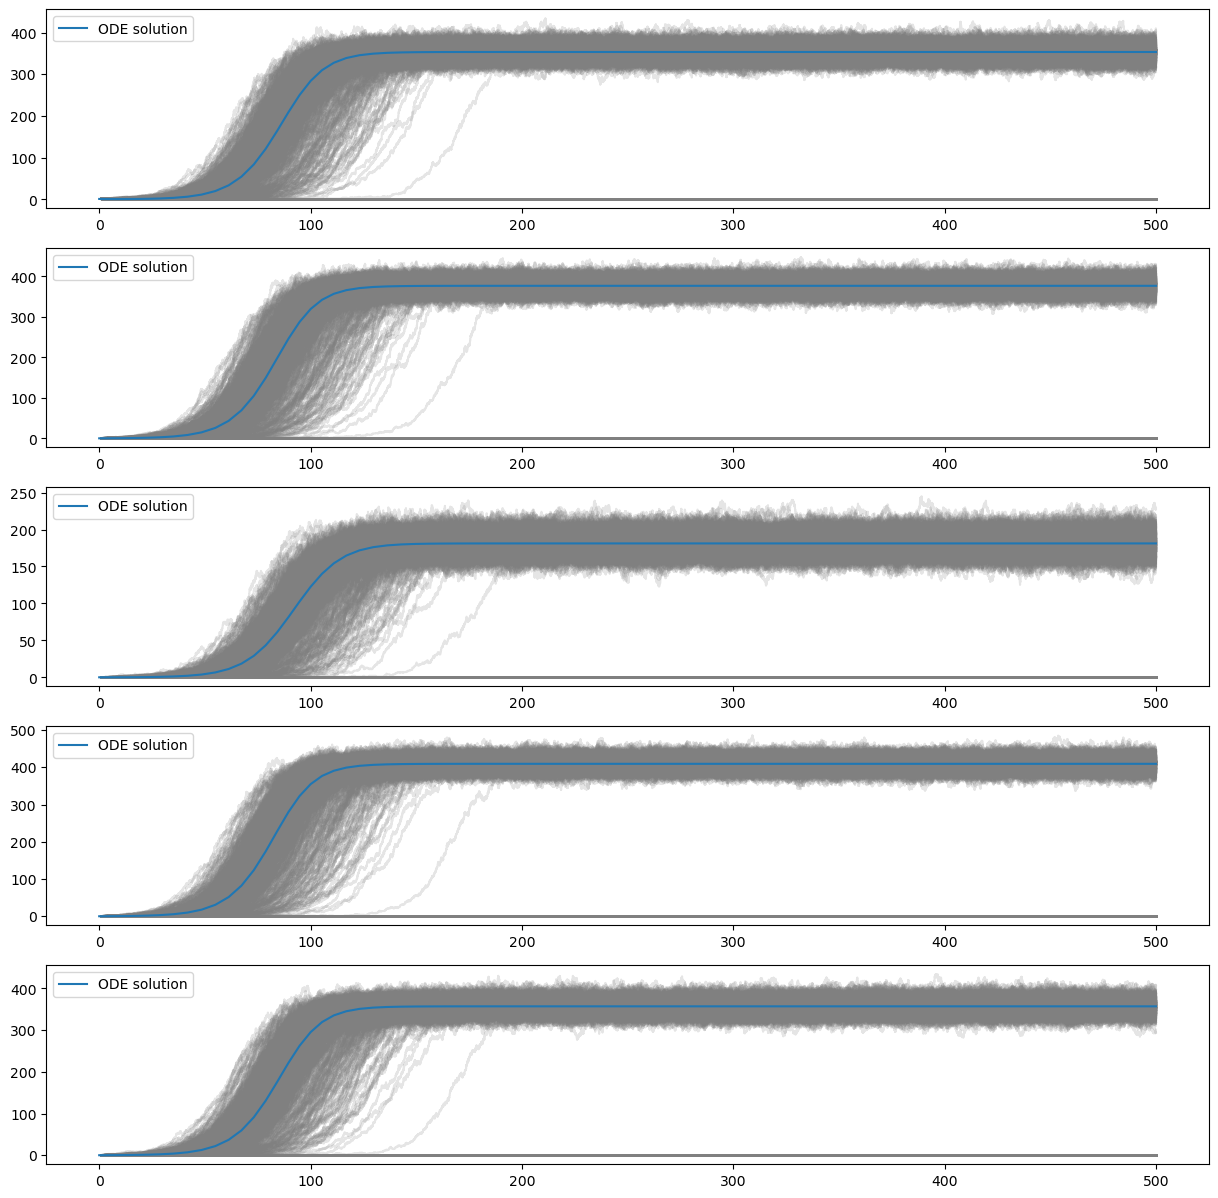

In [39]:
figure()
subplots(Tiles,1,figsize=(15,15))
for i = range(1,Tiles)
    subplot(Tiles,1,i)
    for j = range(1,Iterations)
        plot(LinRange(1,T,convert(Int64,T/dt)),test[j][:,i],alpha=0.2, c="grey")
    end
    plot(sol.t,I_multi[:,i], label="ODE solution")
    legend()
end
#savefig("/Users/claudioascione/Desktop/Grafici/Testing_SEIRS_model/Model_SEIRS_multi_Patch_ODE_vs_stoch", dpi=200)

In [33]:
# Initialize a 3D matrix filled with zeros
depth = length(test)
three_d_matrix_test = zeros(Int64, convert(Int64,T/dt), Tiles, depth)

# Fill the 3D matrix with data from the vector of matrices
for i in 1:depth
    three_d_matrix_test[:, :, i] .= test[i]
end

In [34]:
vec_percent_multi=zeros(Float64, convert(Int64,T/dt), Tiles, 3)
for j = range(1,size(three_d_matrix_test,1))
    for i = range(1,size(three_d_matrix_test,2))
        vec_percent_multi[j,i,:] .= percentile(three_d_matrix_test[j,i,:],[2.5,50,97.5])
    end
end

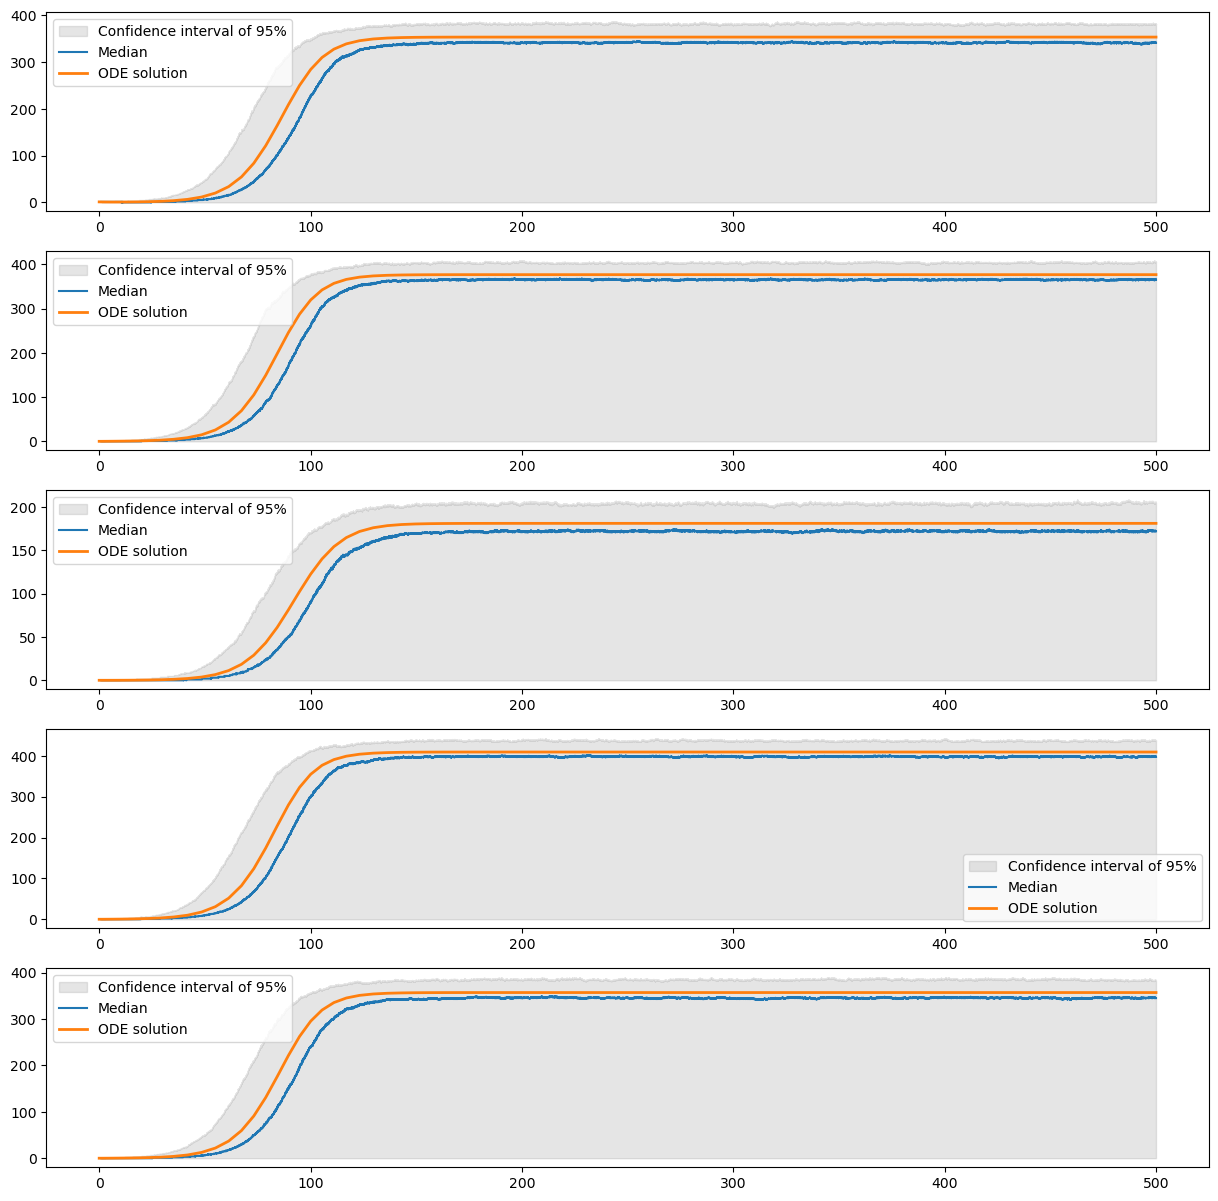

In [40]:
figure()
subplots(size(vec_percent_multi,2),1,figsize=(15,15))
i=1
for i = range(1,size(vec_percent_multi,2))
    subplot(size(vec_percent_multi,2),1,i)
    fill_between(LinRange(1,T,convert(Int64,T/dt)), vec_percent_multi[:,i,1], vec_percent_multi[:,i,3],alpha=0.2, color="grey",label="Confidence interval of 95%")
    plot(LinRange(1,T,convert(Int64,T/dt)),vec_percent_multi[:,i,2],label="Median")
    plot(sol.t,I_multi[:,i],linewidth=2.0,label="ODE solution")
    legend()
end
#savefig("/Users/claudioascione/Desktop/Grafici/Testing_SEIRS_model/Model_SEIRS_multi_Patch_ODE_vs_stoch_CI", dpi=200)

#### Now, we eliminate the stochastic simulation that happen to incur into stochastic extinction

In [36]:
mask=three_d_matrix_test[10000,:,:] .> 0
three_d_matrix_test_no_extinction=three_d_matrix_test[:,:,reduce(&, mask, dims=1)[1,:]]

50000×5×656 Array{Int64, 3}:
[:, :, 1] =
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   ⋮                 
 357  364  184  416  366
 356  362  184  414  365
 356  361  184  413  365
 358  360  183  414  363
 358  360  183  414  364
 358  359  182  417  364
 358  359  182  417  365
 361  359  182  415  365
 361  359  182  413  366
 363  359  182  415  365
 363  358  182  415  364
 363  358  182  414  363

[:, :, 2] =
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0
   1    0    0    0    0

In [37]:
vec_percent_multi_no_extinction=zeros(Float64, convert(Int64,T/dt), Tiles, 3)
for j = range(1,size(three_d_matrix_test_no_extinction,1))
    for i = range(1,size(three_d_matrix_test_no_extinction,2))
        vec_percent_multi_no_extinction[j,i,:] .= percentile(three_d_matrix_test_no_extinction[j,i,:],[2.5,50,97.5])
    end
end

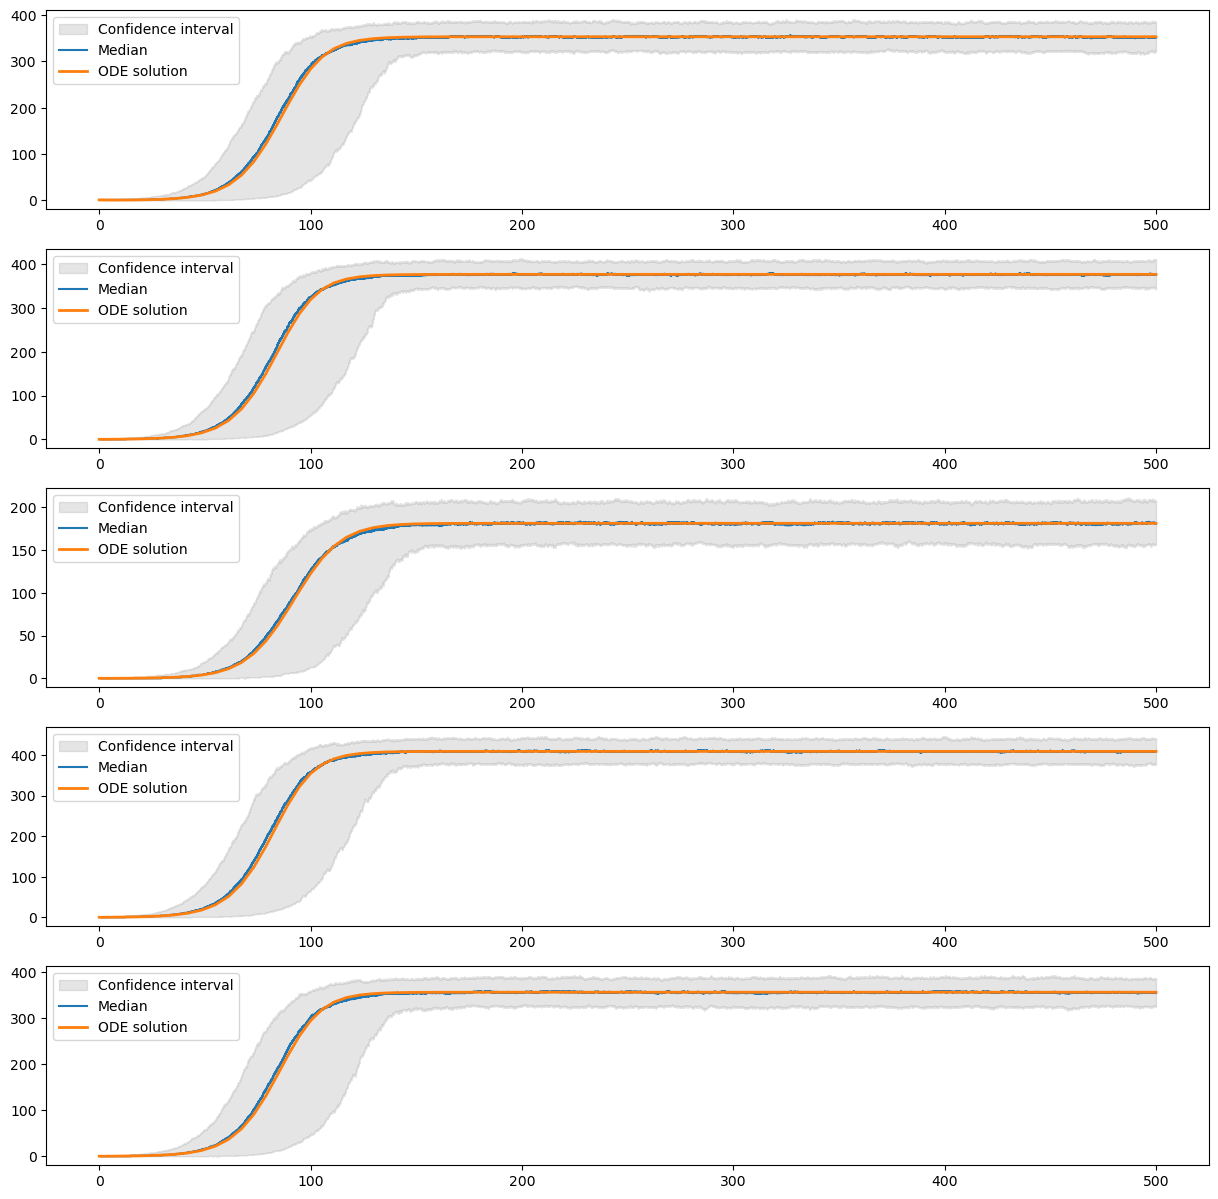

In [41]:
figure()
subplots(size(vec_percent_multi_no_extinction,2),1,figsize=(15,15))
for i = range(1,size(vec_percent_multi_no_extinction,2))
    subplot(size(vec_percent_multi_no_extinction,2),1,i)
    fill_between(LinRange(1,T,convert(Int64,T/dt)), vec_percent_multi_no_extinction[:,i,1], vec_percent_multi_no_extinction[:,i,3],alpha=0.2, color="grey",label="Confidence interval")
    plot(LinRange(1,T,convert(Int64,T/dt)),vec_percent_multi_no_extinction[:,i,2],label="Median")
    plot(sol.t,I_multi[:,i],linewidth=2.0,label="ODE solution")
    legend()
end
#savefig("/Users/claudioascione/Desktop/Grafici/Testing_SEIRS_model/Model_SEIRS_multi_Patch_ODE_vs_stoch_no_extinction_CI", dpi=200)